In [1]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
from matplotlib.gridspec import GridSpec
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
pip install openmeteo-requests

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install requests-cache retry-requests numpy pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 50.09300890420742, 
	"longitude":  18.192600674817953,
	"start_date": "1970-01-01",
	"end_date": "2023-12-31",
	"hourly": ["rain", "is_day"],
	"timezone": "Europe/Berlin"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_rain = hourly.Variables(0).ValuesAsNumpy()
hourly_is_day = hourly.Variables(1).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["rain"] = hourly_rain
hourly_data["is_day"] = hourly_is_day

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe['hour'] = hourly_dataframe['date'].dt.hour


Coordinates 50.08787155151367°N 18.25174903869629°E
Elevation 217.0 m asl
Timezone b'Europe/Berlin' b'CEST'
Timezone difference to GMT+0 7200 s


In [6]:
hourly_dataframe = hourly_dataframe.iloc[2:]
hourly_dataframe.reset_index(drop=True, inplace=True)


In [7]:
weights_workday = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.2, 0.6, 1, 1, 0.7, 0.5, 0.6, 0.8, 0.8, 0.5, 0.8, 1, 1, 0.7, 0.5, 0.3, 0.1, 0.05]
weights_weekend = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.2, 0.6, 1, 1, 1, 1, 1, 1, 1, 1, 0.7, 0.4, 0.05, 0.05, 0.05]


In [8]:
monthly_df = hourly_dataframe

In [9]:
monthly_df.loc[monthly_df['rain'] != 0.0, 'rain'] = 1.0
monthly_df['rain'].unique()

array([0., 1.], dtype=float32)

In [10]:
monthly_df['weekday_or_weekend'] = monthly_df['date'].dt.dayofweek.apply(lambda x: 0 if x < 5 else 1)


In [11]:
monthly_df['rain_index'] = 0  

# Iterate over each row
for i in range(len(monthly_df)):
    # Extract the weekday_or_weekend value
    day_type = monthly_df.at[i, 'weekday_or_weekend']
    
    # Get the weights based on the day type
    weights = np.array(weights_workday) if day_type == 0 else np.array(weights_weekend)
    
    # Perform vectorized multiplication and sum
    monthly_df.at[i, 'rain_index'] = weights[monthly_df.at[i,'hour']] * monthly_df.at[i, 'rain']

C:\Users\2002g\AppData\Local\Temp\ipykernel_22868\1518878264.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  monthly_df.at[i, 'rain_index'] = weights[monthly_df.at[i,'hour']] * monthly_df.at[i, 'rain']


In [12]:
monthly_df['year'] = monthly_df['date'].dt.year
monthly_df['month'] = monthly_df['date'].dt.month

In [13]:
sum_index_df = monthly_df.groupby(['year', 'month'])['rain_index'].sum().reset_index()

In [14]:
sum_index_df.head()

,year,month,rain_index
0,1970,1,23.75
1,1970,2,16.75
2,1970,3,43.80
3,1970,4,93.55
4,1970,5,108.50


In [15]:
yearly = sum_index_df.groupby('year')['rain_index'].sum().reset_index()

In [16]:
monthly_df.head()

,date,rain,is_day,hour,weekday_or_weekend,rain_index,year,month
0,1970-01-01 00:00:00+00:00,0.0,0.0,0,0,0.0,1970,1
1,1970-01-01 01:00:00+00:00,0.0,0.0,1,0,0.0,1970,1
2,1970-01-01 02:00:00+00:00,0.0,0.0,2,0,0.0,1970,1
3,1970-01-01 03:00:00+00:00,0.0,0.0,3,0,0.0,1970,1
4,1970-01-01 04:00:00+00:00,0.0,0.0,4,0,0.0,1970,1


Text(0.5, 1.0, 'Wkład miesięcy w łączne opady - Racibórz')

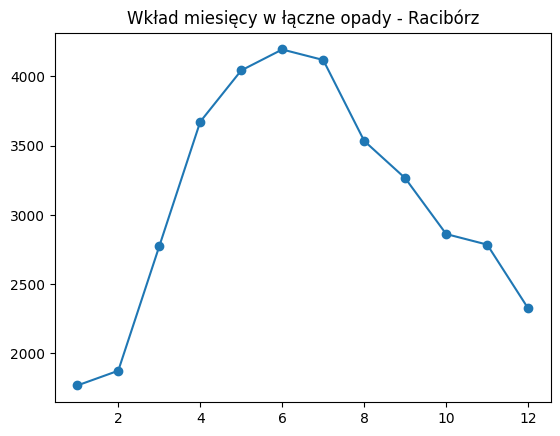

In [21]:
cp = monthly_df.groupby('month')['rain_index'].sum().reset_index()
plt.plot(cp['month'], cp['rain_index'], marker='o')
plt.title("Wkład miesięcy w łączne opady - Racibórz")

In [18]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


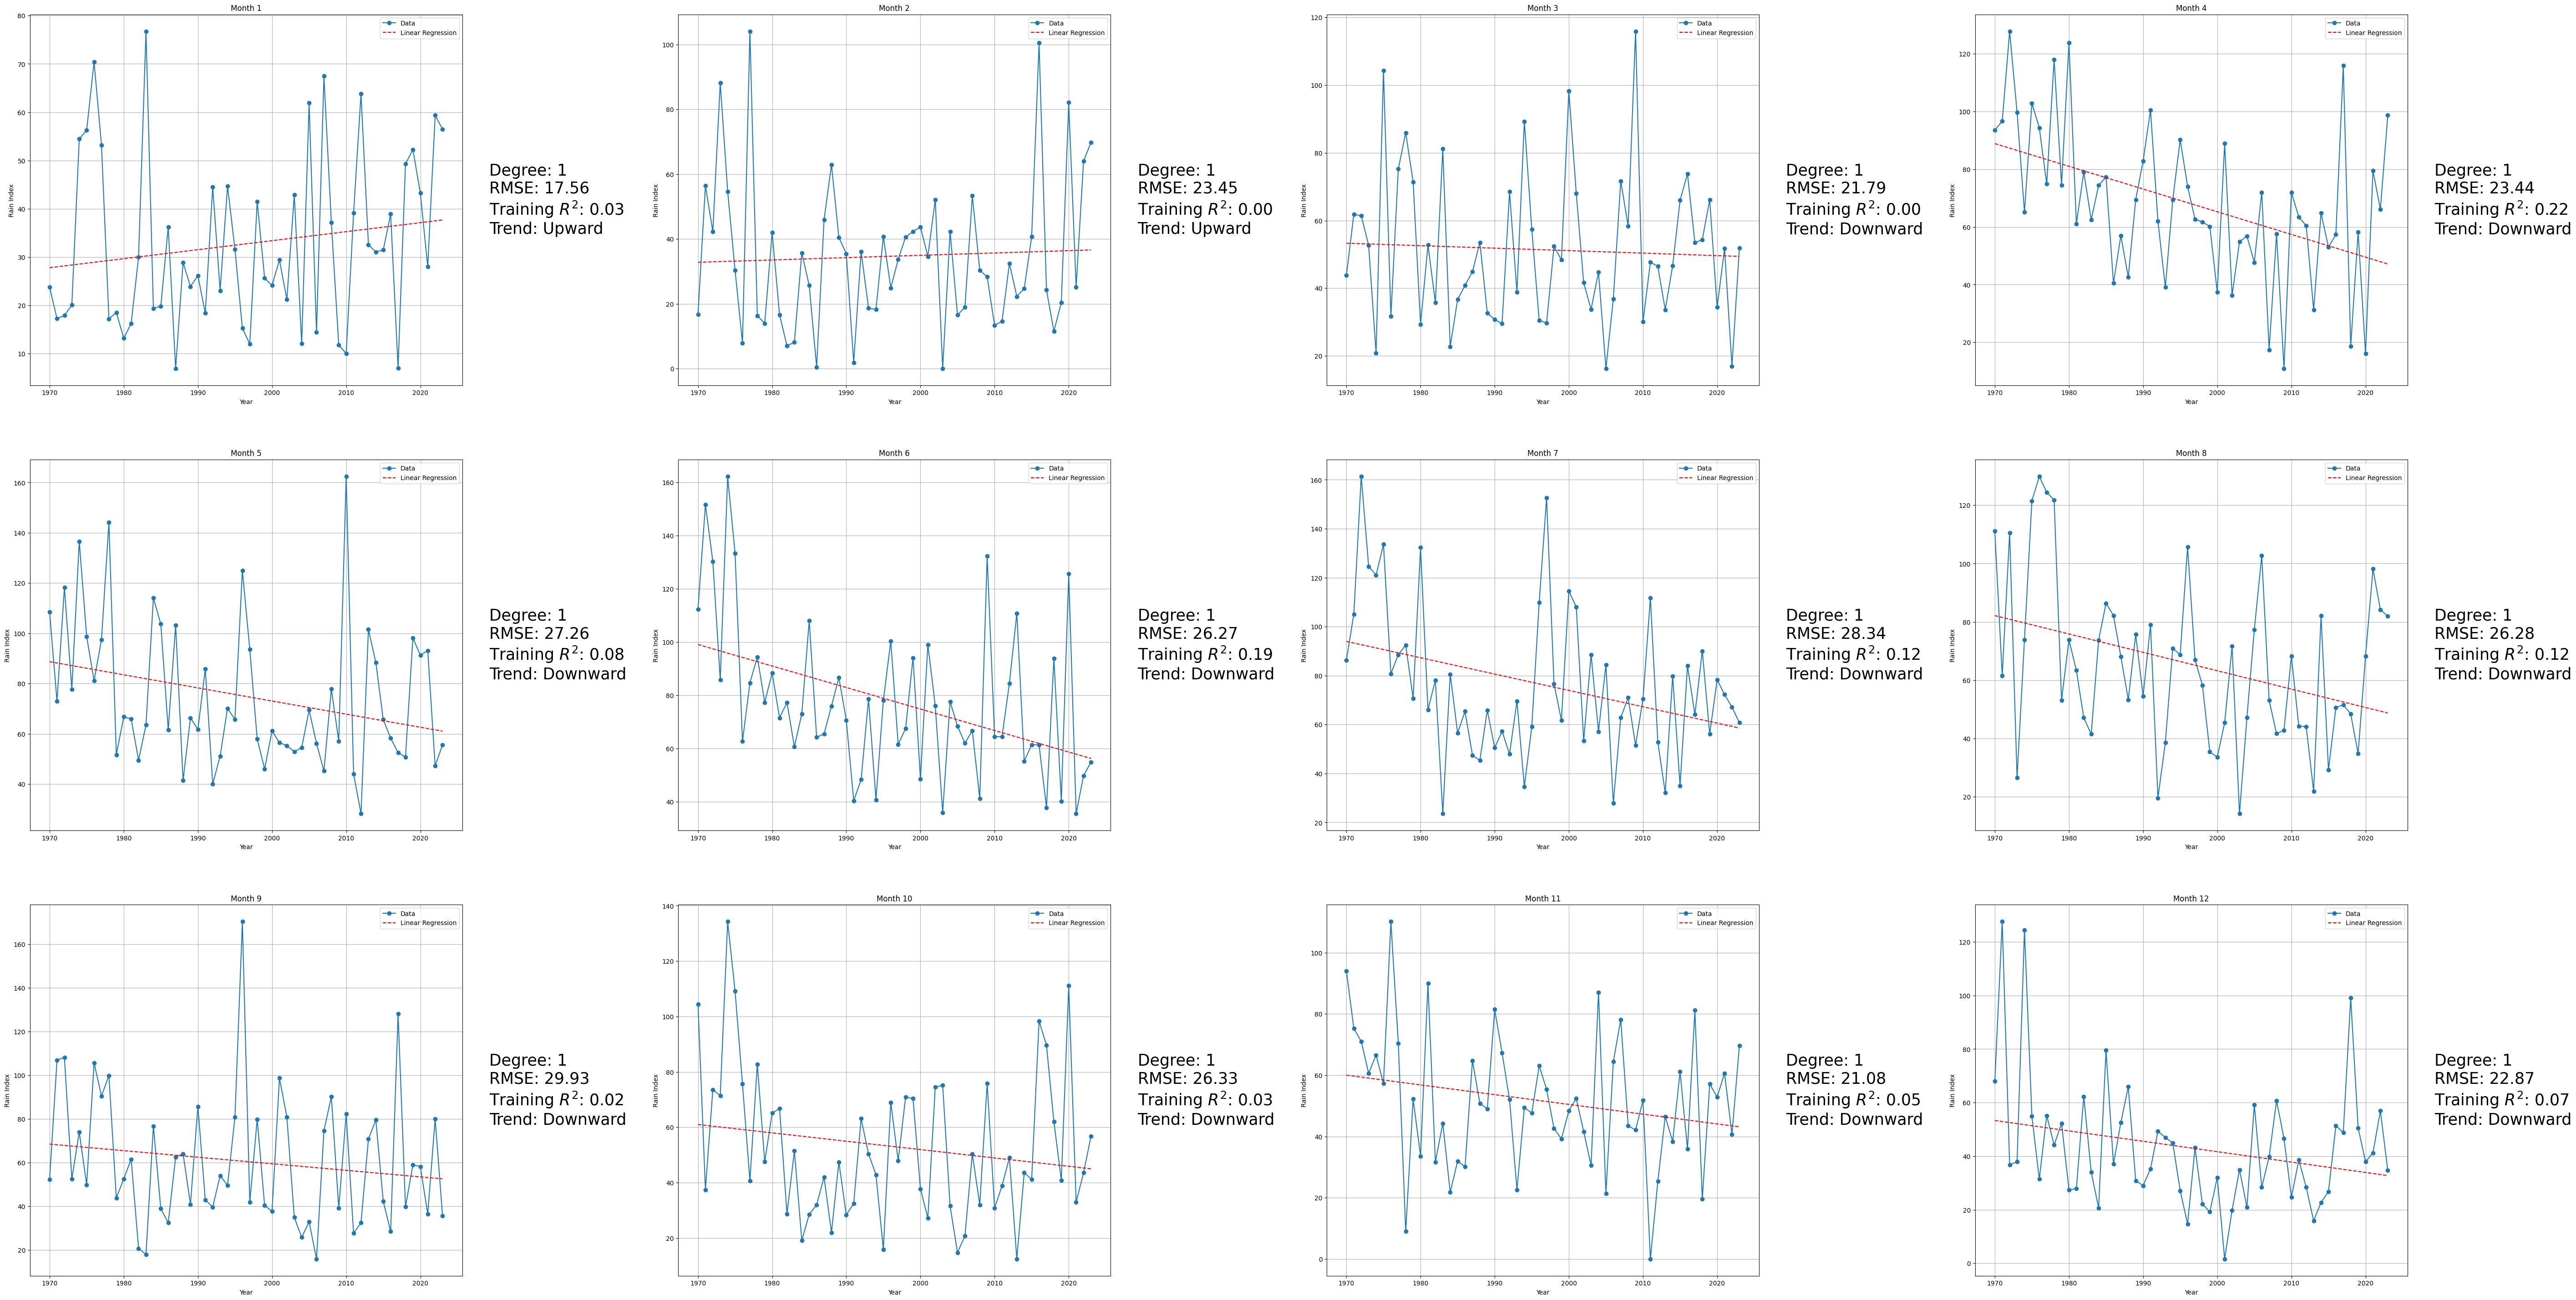

In [19]:
# Function to perform polynomial regression and evaluate the model
def evaluate_polynomial_regression(X, y, degree):   
    
    # Fit polynomial regression
    p = Polynomial.fit(X.flatten(), y, degree)
    
    # Generate predictions for validation set
    y_pred = p(X.flatten())
    
    # Calculate mean squared error for the validation set
    mse = mean_squared_error(y, y_pred)
    
    # Calculate R-squared for the validation set
    ss_res_val = np.sum((y - y_pred) ** 2)
    ss_tot_val = np.sum((y - np.mean(y)) ** 2)
    r_squared_val = 1 - (ss_res_val / ss_tot_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    return p, rmse, r_squared_val



# Set up the figure with a 4 x 3 grid of plots
fig = plt.figure(figsize=(72, 36))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Define a grid with two columns for each plot
gs = GridSpec(3, 8, width_ratios=[4, 1, 4, 1, 4, 1, 4, 1], wspace=0.2)

# Iterate over each month
for i, month in enumerate(range(1, 13)):
    # Filter the DataFrame for the current month
    month_df = sum_index_df[sum_index_df['month'] == month]
    
    # Split the data into training and validation sets
    X = month_df[['year']].values
    y = month_df['rain_index'].values
    
    
    # Fit polynomial regression with degree 1 (linear regression)
    model, rmse, r_squared_val = evaluate_polynomial_regression(X, y, 1)
    
    # Generate predictions for validation set
    y_pred = model(X.flatten())
    
    # Calculate mean squared error for the validation set
    mse_val = mean_squared_error(y, y_pred)
    
    # Calculate R-squared for the best model on training data
    y_fit = model(X.flatten())
    ss_res = np.sum((y - y_fit) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Generate x values for plotting the linear regression line
    x_values = np.linspace(month_df['year'].min(), month_df['year'].max(), 100)
    y_values = model(x_values)
    
    # Plot the index over the years for the current month
    ax1 = fig.add_subplot(gs[i//4, i%4 * 2])
    ax1.plot(month_df['year'], month_df['rain_index'], marker='o', label='Data')
    ax1.plot(x_values, y_values, color='red', linestyle='--', label=f'Linear Regression')
    ax1.set_title(f'Month {month}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Rain Index')
    ax1.grid(True)
    ax1.legend()
    
    # Determine the direction of the trend
    trend_direction = "Upward" if y_values[-1] > y_values[0] else "Downward"
    
    # Add text information in the right panel
    ax2 = fig.add_subplot(gs[i//4, i%4 * 2 + 1])
    ax2.axis('off')  # Hide the axis
    textstr = (f'Degree: 1\n'
               f'RMSE: {np.sqrt(mse_val):.2f}\n'
               f'Training $R^2$: {r_squared:.2f}\n'              
               f'Trend: {trend_direction}')
    ax2.text(-0.25, 0.5, textstr, fontsize=25, verticalalignment='center', horizontalalignment='left')

plt.show()


c:\Users\2002g\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Users\2002g\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Users\2002g\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Users\2002g\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
c:\Users\2002g\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\polynomial\polynomial.py:1362: RankWarning: The fit may be poorly con

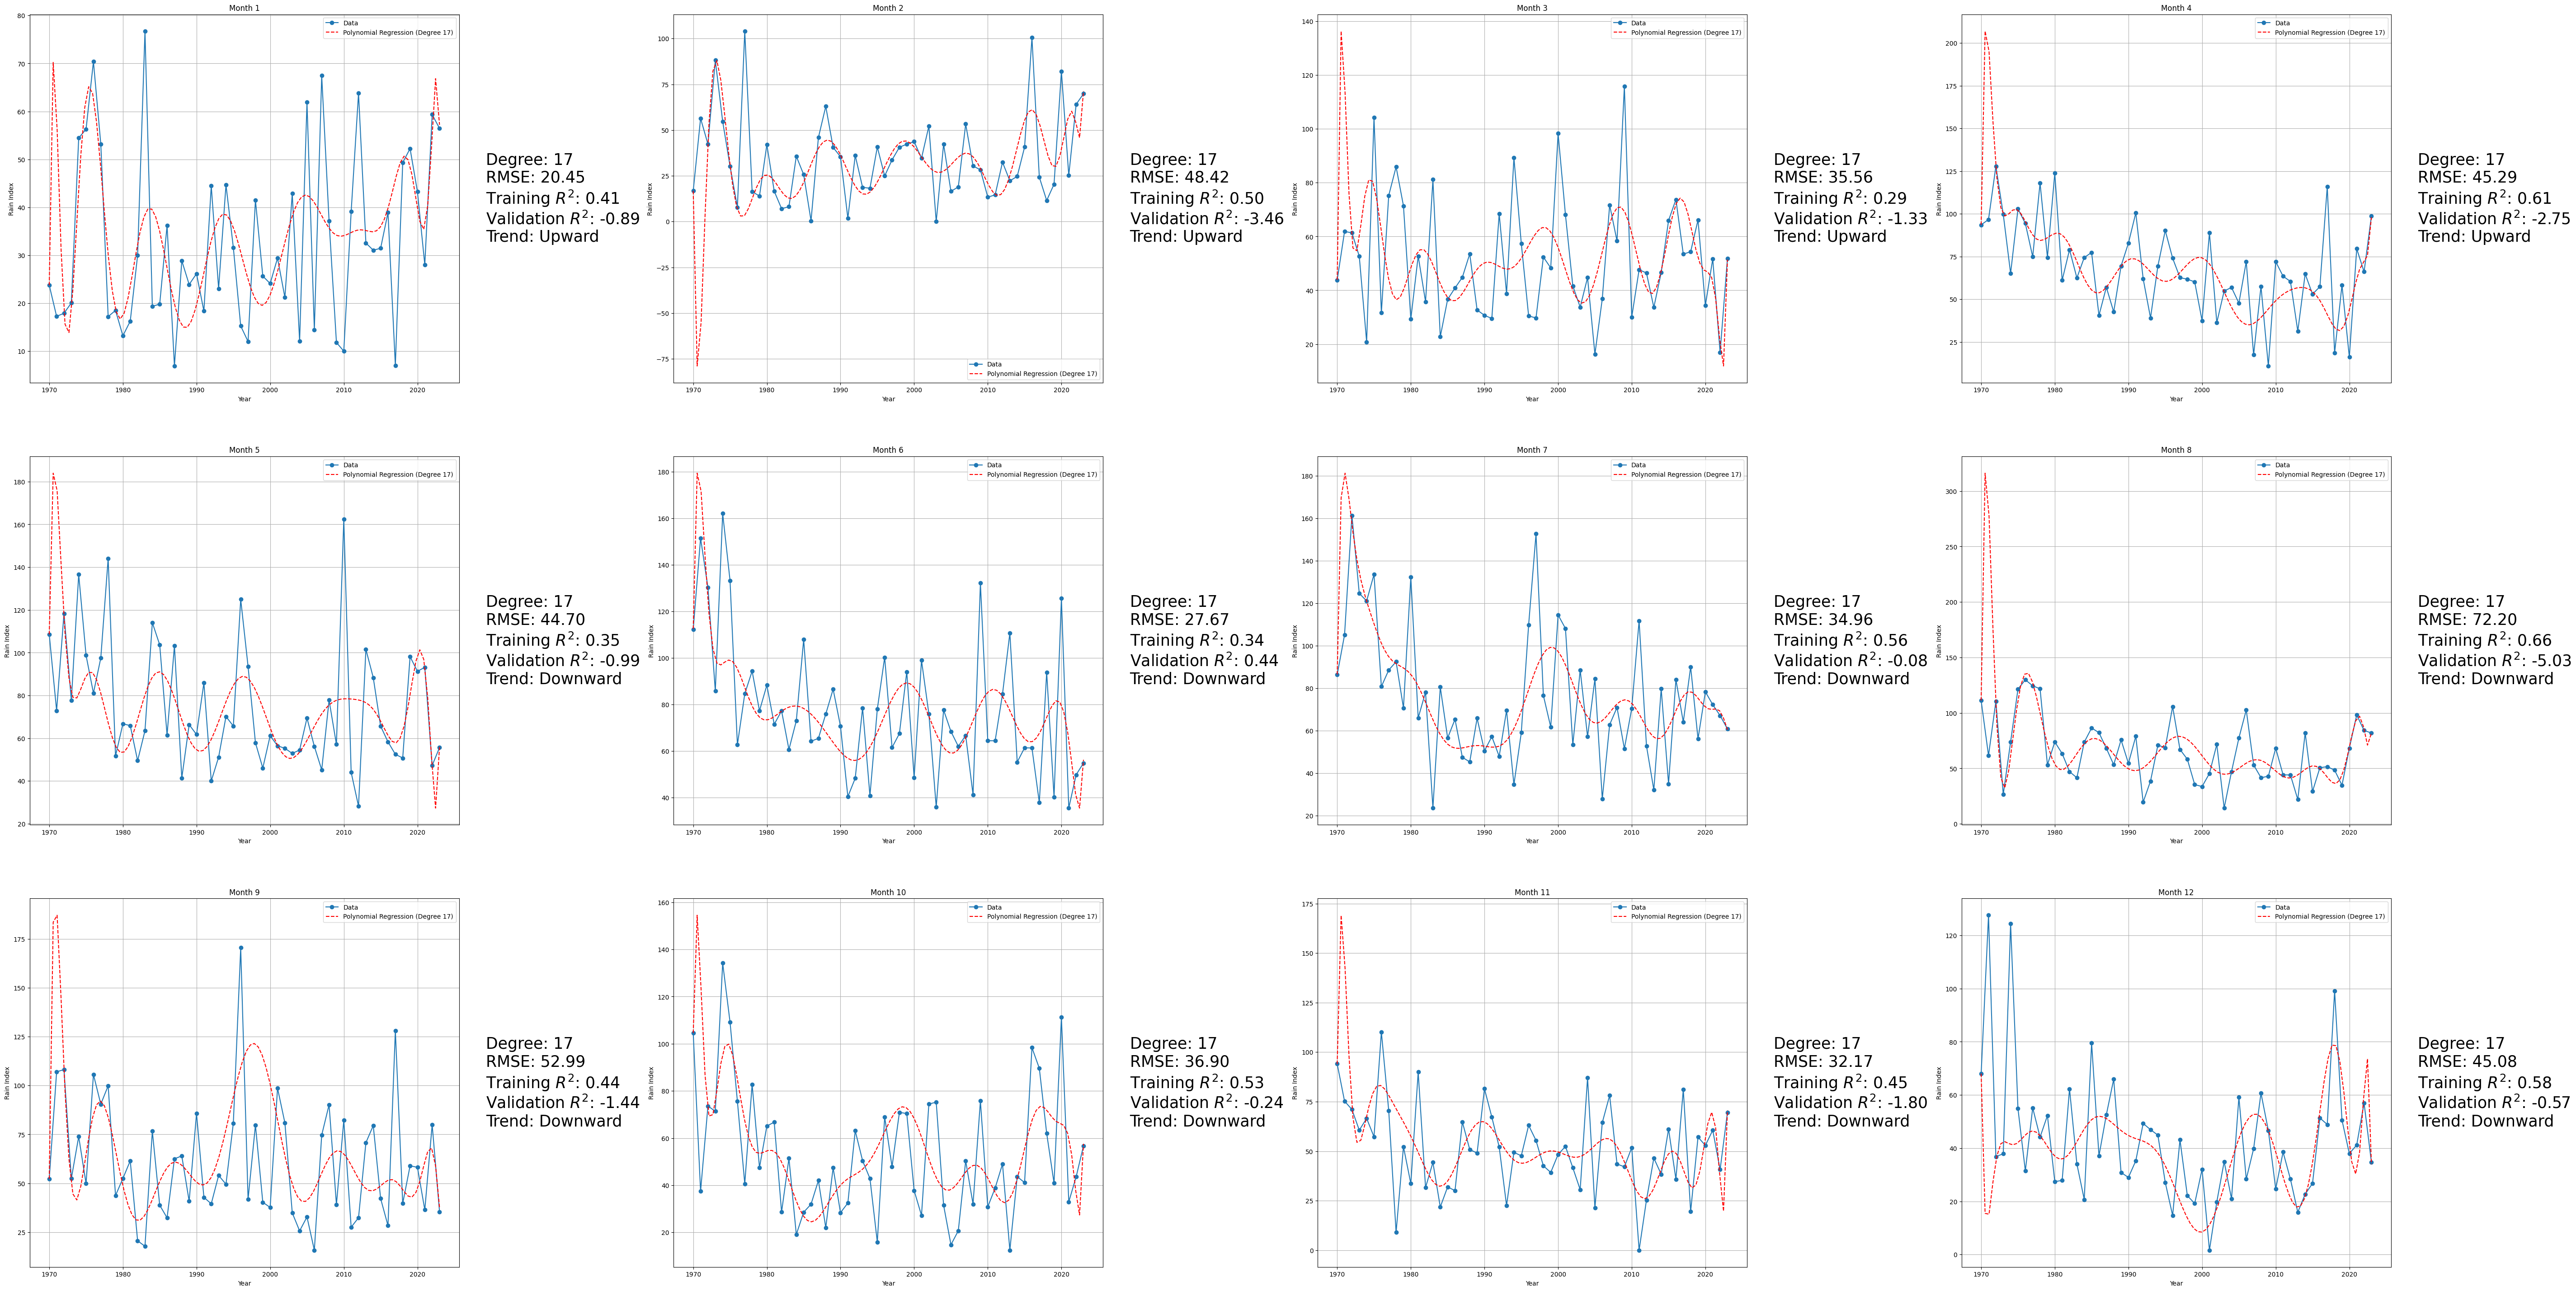

In [20]:
# Function to perform polynomial regression and evaluate the model
def evaluate_polynomial_regression(X, y, degree):
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)
    
    # Fit polynomial regression
    p = Polynomial.fit(X_train.flatten(), y_train, degree)
    
    # Generate predictions for validation set
    y_val_pred = p(X_val.flatten())
    
    # Calculate mean squared error for the validation set
    mse = mean_squared_error(y_val, y_val_pred)
    
    # Calculate R-squared for the validation set
    ss_res_val = np.sum((y_val - y_val_pred) ** 2)
    ss_tot_val = np.sum((y_val - np.mean(y_val)) ** 2)
    r_squared_val = 1 - (ss_res_val / ss_tot_val)
    
    # Calculate RMSE
    rmse = np.sqrt(mse)
    
    return p, rmse, r_squared_val

# Function to find the best polynomial degree using combined data from all months
def find_best_degree(sum_index_df, max_degree=100):
    X = sum_index_df[['year']].values
    y = sum_index_df['rain_index'].values
    
    best_degree = 0
    best_rmse = float('inf')
    best_model = None
    best_r_squared_val = 0
    
    for degree in range(1, max_degree + 1):
        model, rmse, r_squared_val = evaluate_polynomial_regression(X, y, degree)
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_degree = degree
            best_model = model
            best_r_squared_val = r_squared_val
            
    return best_degree, best_rmse, best_r_squared_val

# Find the best polynomial degree for the combined data of all months
best_degree, _, _ = find_best_degree(sum_index_df)

# Set up the figure with a 4 x 3 grid of plots
fig = plt.figure(figsize=(72, 36))

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Define a grid with two columns for each plot
gs = GridSpec(3, 8, width_ratios=[4, 1, 4, 1, 4, 1, 4, 1], wspace=0.2)

# Iterate over each month and apply the best polynomial degree found
for i, month in enumerate(range(1, 13)):
    # Filter the DataFrame for the current month
    month_df = sum_index_df[sum_index_df['month'] == month]
    
    # Split the data into training and validation sets
    X = month_df[['year']].values
    y = month_df['rain_index'].values
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=69)
    
    # Fit polynomial regression with the best degree
    best_model = Polynomial.fit(X_train.flatten(), y_train, best_degree)
    
    # Generate predictions for validation set
    y_val_pred = best_model(X_val.flatten())
    
    # Calculate mean squared error for the validation set
    mse_val = mean_squared_error(y_val, y_val_pred)
    
    # Calculate R-squared for the best model on training data
    y_fit_train = best_model(X_train.flatten())
    ss_res_train = np.sum((y_train - y_fit_train) ** 2)
    ss_tot_train = np.sum((y_train - np.mean(y_train)) ** 2)
    r_squared_train = 1 - (ss_res_train / ss_tot_train)
    
    # Calculate R-squared for the best model on validation data
    ss_res_val = np.sum((y_val - y_val_pred) ** 2)
    ss_tot_val = np.sum((y_val - np.mean(y_val)) ** 2)
    r_squared_val = 1 - (ss_res_val / ss_tot_val)
    
    # Generate x values for plotting the polynomial curve
    x_values = np.linspace(month_df['year'].min(), month_df['year'].max(), 100)
    y_values = best_model(x_values)
    
    # Plot the index over the years for the current month
    ax1 = fig.add_subplot(gs[i//4, i%4 * 2])
    ax1.plot(month_df['year'], month_df['rain_index'], marker='o', label='Data')
    ax1.plot(x_values, y_values, color='red', linestyle='--', label=f'Polynomial Regression (Degree {best_degree})')
    ax1.set_title(f'Month {month}')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Rain Index')
    ax1.grid(True)
    ax1.legend()
    
    # Determine the direction of the trend
    trend_direction = "Upward" if y_values[-1] > y_values[0] else "Downward"
    
    # Add text information in the right panel
    ax2 = fig.add_subplot(gs[i//4, i%4 * 2 +1])
    ax2.axis('off')  # Hide the axis
    textstr = (f'Degree: {best_degree}\n'
               f'RMSE: {np.sqrt(mse_val):.2f}\n'
               f'Training $R^2$: {r_squared_train:.2f}\n'
               f'Validation $R^2$: {r_squared_val:.2f}\n'
               f'Trend: {trend_direction}')
    ax2.text(-0.25, 0.5, textstr, fontsize=25, verticalalignment='center', horizontalalignment='left')

plt.show()
